# API TDD (Test-Driven Development)

The purpose of this notebook is to work out how a user may want to use the library. Code will be written using the desired API/syntax, and then the library will be adjusted. Functions that are not of interest to a typical user will be rendered private (\_privatename single underscore convention).

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


Setup: user has v/J data as python lists

In [5]:
# load the parameters used by Rioux for his example at:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
from simulation_data import rioux

In [6]:
v, J = rioux()
print(v)
print(J)

[430. 265. 300.]
[[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


In [7]:
from nmrtools import qm

In [8]:
spectrum = qm.spectrum(v, J, normalize=True)

In [9]:
from nmrtools.nmrplot import mplplot

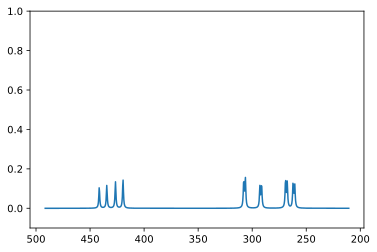

In [10]:
mplplot(spectrum)

In [11]:
from nmrtools.nmrplot import mplplot_stick

In [12]:
x, y = zip(*spectrum)
x = np.array(x)
y = np.array(y)
x, y

(array([260.66152857, 262.18930345, 267.62991551, 269.15769038,
        291.31911367, 292.84688854, 306.32295186, 307.85072673,
        419.51935776, 426.48774469, 434.52319595, 441.49158288]),
 array([0.23011249, 0.24876062, 0.24855579, 0.27256417, 0.22882003,
        0.21381231, 0.2925168 , 0.26486802, 0.29107245, 0.26629868,
        0.23004586, 0.21257278]))

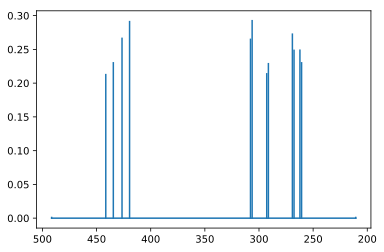

In [13]:
mplplot_stick(x, y)

__How does a user want their spectrum?__ Currently a list of tuples is provided. Some routines may be better implemented if the spectrum remained a numpy array. e.g. compile_spectrum provides a 2D array of `[[frequency, intensity]...]`. normalize_spectrum then separates into frequency and intensity arrays, processes the latter, then puts them back together.

Need to survey how the most common plotting libraries handle x, y data. Two scenarios: lineshape, and stick.

Note that a spectrum with [(v, I)...] format can be easily converted to [v...], [I...]:
`v, I = zip(*spectrum)`


__What is a multiplet, and what can you do with it?__ It has v, I, and J information. If multiplied, the intensity increases. If added, you get a spectrum. < and > may not make sense (but could be v order; probably not I order). Challenge: representation? Can you get it to determine dt, td etc?

In [14]:
from nmrtools.firstorder import Multiplet

In [15]:
# 1200 Hz, 2H, td, J= 7.1, 1.1 Hz
td = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])

In [16]:
from nmrtools.nmrplot import mplplot_stick

In [17]:
x =  np.array([x_ for x_, y_ in td.peaklist])
y =  np.array([y_ for x_, y_ in td.peaklist])

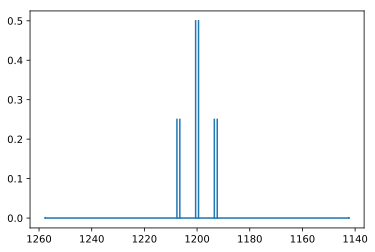

In [18]:
mplplot_stick(x, y)

In [19]:
import timeit

In [20]:
from nmrtools.dnmr import DnmrTwoSinglets

In [21]:
from nmrtools.nmrplot import dnmrplot_2spin

In [22]:
import matplotlib.pyplot as plt

In [26]:
def popplot(x, y, invertx=True):
    """Create a pop-up plot of x, y data.

    Arguments
    ---------
    x, y: np.array-like objects of x and y coordinate data.
    invertx: invert the x axis if true (the standard for NMR spectra).
    """
    plt.plot(x, y)
    if invertx:
        plt.gca().invert_xaxis()
    plt.show()

In [29]:
klass = DnmrTwoSinglets(165.00, 135.00, 65.9, 0.50, 0.50, 0.50)

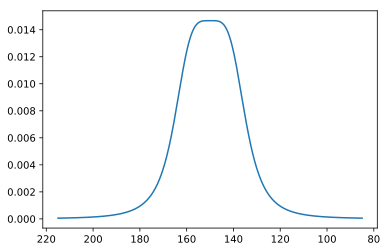

In [30]:
popplot(*klass.spectrum())

In [33]:
klass.limits = (-50, 215)

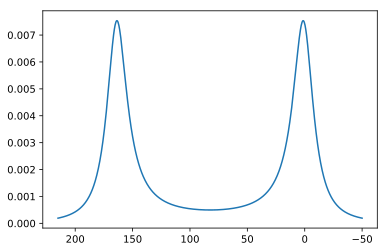

In [34]:
popplot(*klass.spectrum())

In [ ]:
%%timeit
twospin_runner(dnmr_2spin)

In [ ]:
%%timeit
twospin_runner(two_spin)

In [ ]:
%%timeit
twospin_runner(d2s_func)

In [ ]:
%%timeit
twospin_runner(reich)

In [ ]:
%%timeit
klass.spectrum()

In [ ]:
class DnmrTwoSinglets:
    """
    A DNMR simulation for two uncoupled nuclei undergoing exchange.
    """

    _pi = np.pi
    _pi_squared = _pi ** 2

    def __init__(self, va=1, vb=0, k=0.01, wa=0.5, wb=0.5, pa=0.5):
        """
        Initialize the system with the required parameters:
        :param va: Frequency of nucleus a
        :param vb: Frequency of nucleus b (must be < va)
        :param k: Rate of nuclear exchange
        :param wa: With at half height for va signal at the slow exchange limit
        :param wb: With at half height for vb signal at the slow exchange limit
        :param pa: Fractional population of state 'a'
        """
        # Idea is to complete the frequency-independent calculations when the
        #  class is instantiated, and thus calculations may be faster.
        self._va = va
        self._vb = vb
        self._k = k
        self._wa = wa
        self._wb = wb
        self._pa = pa
        self.l_limit = vb - 50
        self.r_limit = va + 50
        
        self._set_T2a()
        self._set_T2b()
        self._set_pb()
        self._set_tau()
        self._set_dv()
        self._set_Dv()
        self._set_P()
        self._set_p()
        self._set_Q()
        self._set_R()
        self._set_r()

    def _set_T2a(self):
        self._T2a = 1 / (self._pi * self._wa)
        
    def _set_T2b(self):
        self._T2b = 1 / (self._pi * self._wb)
        
    def _set_pb(self):
        self._pb = 1 - self._pa
        
    def _set_tau(self):
        self._tau = self._pb / self._k
        
    def _set_dv(self):
        self._dv = self._va - self._vb
        
    def _set_Dv(self):
        self._Dv = (self._va + self._vb) / 2
        
    def _set_P(self):
        self._P = self._tau * (1 / (self._T2a * self._T2b) + self._pi_squared * (self._dv ** 2)) \
            + (self._pa / self._T2a + self._pb / self._T2b)
        
    def _set_p(self):
        self._p = 1 + self._tau * ((self._pb / self._T2a) + (self._pa / self._T2b))
        
    def _set_Q(self):
        self._Q = self._tau * (- self._pi * self._dv * (self._pa - self._pb))
        
    def _set_R(self):
        self._R = self._pi * self._dv * self._tau * ((1 / self._T2b) - (1 / self._T2a)) \
            + self._pi * self._dv * (self._pa - self._pb)
    def _set_r(self):
        self._r = 2 * self._pi * (1 + self._tau * ((1 / self._T2a) + (1 / self._T2b)))

    @property
    def va(self):
        return self._va
    
    @va.setter
    def va(self, value):
        self._va = value
        self._set_vab_dependencies()
        
    def _set_vab_dependencies(self):
        self._set_dv()
        self._set_Dv()
        self._set_P()
        self._set_Q()
        self._set_R()
    
    @property
    def vb(self):
        return self._vb
    
    @vb.setter
    def vb(self, value):
        self._vb = value
        self._set_vab_dependencies()
    
    @property
    def k(self):
        return self._k
    
    @k.setter
    def k(self, value):
        self._k = value
        self._set_tau()
        self._set_p()
        self._set_P()
        self._set_Q()
        self._set_R()
        self._set_r()

    @property
    def wa(self):
        return self._wa
    
    @wa.setter
    def wa(self, value):
        self._wa = value
        self._set_T2a()
        self._set_wab_dependencies()
        
    def _set_wab_dependencies(self):
        self._set_p()
        self._set_P()
        self._set_R()
        self._set_r()
        
    @property
    def wb(self):
        return self._wb
    
    @wb.setter
    def wb(self, value):
        self._wb = value
        self._set_T2b()
        self._set_wab_dependencies()
        
    @property
    def pa(self):
        return self._pa
    
    @pa.setter
    def pa(self, value):
        self._pa = value
        self._set_pb()
        self._set_tau()
        self._set_p()
        self._set_P()
        self._set_Q()
        self._set_R()
        self._set_r()
    
    def intensity(self, v):
        """
        Yield a function for the lineshape for TwoSinglets
        :param v: frequency
        :return: a frequency-dependent function that returns the intensity of
        the spectrum at frequency v
        """
        # TODO: add to docstring
        p = self._p
        Dv = self._Dv
        P = self._P
        Q = self._Q
        R = self._R
        r = self._r
        tau = self._tau
        Dv -= v
        P -= tau * 4 * self._pi_squared * (Dv ** 2)
        Q += tau * 2 * self._pi * Dv
        R += Dv * r
        return (P * p + Q * R) / (P ** 2 + R ** 2)

    def spectrum(self):
        """
        Calculate a DNMR spectrum, using the parameters TwoSinglets was
        instantiated with.
        :return: a tuple of numpy arrays (x = numpy linspace representing
        frequencies, y = numpy array of intensities along those frequencies)pwd
        """
        x = np.linspace(self.l_limit, self.r_limit, 800)
        y = self.intensity(x)

        return x, y


In [ ]:
klass = DnmrTwoSinglets(165.00, 135.00, 65.9, 0.50, 0.50, 0.50)

In [ ]:
popplot(*klass.spectrum())

In [ ]:
klass.wb

In [ ]:
klass.wb = 0.01
klass.wb

In [ ]:
klass.k = 65.9
popplot(*klass.spectrum())

In [ ]:
def d2s_partial(va, vb, ka, wa, wb, pa):
    pi = np.pi
    pi_squared = pi ** 2
    T2a = 1 / (pi * wa)
    T2b = 1 / (pi * wb)
    pb = 1 - pa
    tau = pb / ka
    dv = va - vb
    Dv = (va + vb) / 2
    P = tau * (1 / (T2a * T2b) + pi_squared * (dv ** 2)) + (pa / T2a + pb / T2b)
    p = 1 + tau * ((pb / T2a) + (pa / T2b))
    Q = tau * (- pi * dv * (pa - pb))
    R = pi * dv * tau * ((1 / T2b) - (1 / T2a)) + pi * dv * (pa - pb)
    r = 2 * pi * (1 + tau * ((1 / T2a) + (1 / T2b)))

    def maker(v):
        """
        Scheduled for refactoring.
        :param v: frequency
        :return: function that calculates the intensity at v
        """
        # TODO: fix docstring, explain _P _Q etc correlate to P, Q etc in lit.
        # FIXED: previous version of this function used
        # nonlocal Dv, P, Q, R
        # but apparently when function called repeatedly these values would
        # become corrupted (turning into arrays?!)
        # Solution: add underscores to create copies of any variables in
        # outer scope whose values are changed in the inner scope.

        _Dv = Dv - v
        _P = P - tau * 4 * pi_squared * (_Dv ** 2)
        _Q = Q + tau * 2 * pi * _Dv
        _R = R + _Dv * r
        return(_P * p + _Q * _R) / (_P ** 2 + _R ** 2)
    return maker

In [ ]:
a = np.random.random(100) * 100
b = np.random.random(100) * 10
testspec = list(zip(a, b))
testspec[:10]

In [ ]:
from nmrtools.firstorder import add_peaks

In [ ]:
from statistics import mean

def new_add_peaks(plist):
    v, i = zip(*plist)
    average_v = mean(v)
    total_i = sum(i)
    return average_v, total_i

In [ ]:
%%timeit
add_peaks(testspec)

In [ ]:
%%timeit
new_add_peaks(testspec)

In [ ]:
add_peaks(testspec)